In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import google.colab
import os
import random
from tqdm import tqdm

In [ ]:
def set_seed(seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [ ]:
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/Sudoku Project/"
dataset_path = "/content/drive/MyDrive/Sudoku Project/sudoku_grids_dataset"

20250322_115601_detection.jpg
(400, 400) uint8


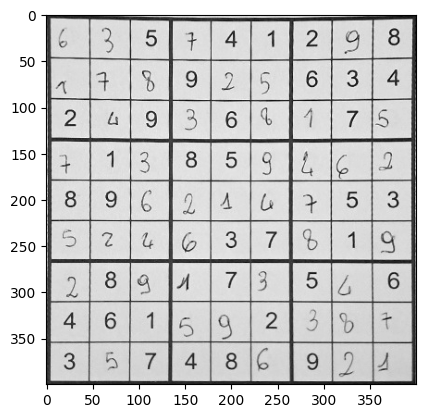

valid_grid_192_2025-04-28_21-09-17_detection.jpg
(400, 400) uint8


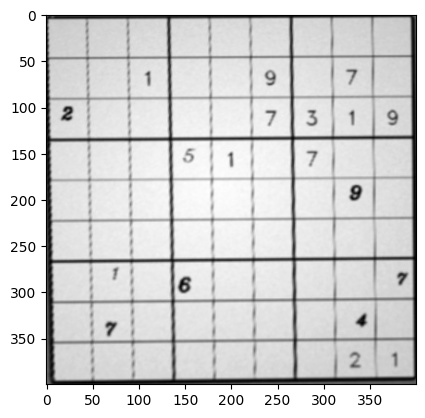

In [ ]:
for folder in os.listdir(dataset_path):
  folder_list = [filename for filename in os.listdir(os.path.join(dataset_path, folder))]
  print(folder_list[0])
  image = plt.imread(os.path.join(dataset_path, f"{folder}/{folder_list[0]}"))
  plt.imshow(image, cmap="gray")
  print(image.shape, image.dtype)
  plt.show()

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [ ]:
print(f"Dataset size: {len(dataset)} images")
print(f"Class mapping: {dataset.class_to_idx}")

Dataset size: 780 images
Class mapping: {'invalid': 0, 'valid': 1}


In [ ]:
sample_img, _ = dataset[0]
print(f"Sample image shape: {sample_img.shape}")

Sample image shape: torch.Size([1, 400, 400])


In [ ]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = 8,
                                           shuffle=True,
                                           num_workers=2
                                           )

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size = 8,
                                           shuffle=False,
                                           num_workers=2
                                           )

(tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]]), 1)
torch.Size([1, 400, 400]) torch.float32
tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]])


torch.Size([8, 1, 400, 400]) torch.float32
torch.Size([8]) torch.int64


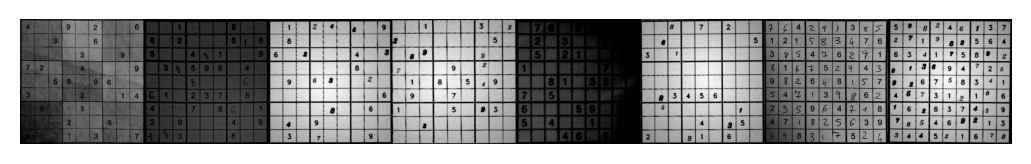

In [ ]:
print(train_set[0])
print(train_set[0][0].shape, train_set[0][0].dtype)
print(train_set[0][0])

#function to visualize the images
def show_batch(images):
  g = torchvision.utils.make_grid(images, nrow=8)
  g = g.numpy().transpose((1, 2, 0))
  plt.figure(dpi=200)
  plt.imshow(g)
  plt.axis("off")
  plt.show()

images, labels = next(iter(train_loader))
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)
show_batch(images)

### Model

In [ ]:
class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = torch.nn.Sequential(
        self.make_block(1, 16),
        self.make_block(16, 32),
        self.make_block(32, 64),
        self.make_block(64, 128),
        self.make_block(128, 256),
        torch.nn.AdaptiveAvgPool2d(1)
    )

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(256, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    features = self.feature_extractor(x).squeeze(3).squeeze(2)
    probs = self.classifier(features)
    return probs

  def make_block(self, in_channels, out_channels):
    # Conv -> Norm -> ReLU -> Conv -> Norm -> ReLU -> Dropout
    block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2)
        )
    return block

classifier = Classifier()
x = torch.zeros(32, 1, 160, 160)
features = classifier(x)
print(x.shape, "->", features.shape)
nparams = sum(p.numel() for p in classifier.parameters())
print("Number of parameters:", nparams)

torch.Size([32, 1, 160, 160]) -> torch.Size([32, 1])
Number of parameters: 1180721


### Training

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
classifier.to(DEVICE)

cuda


Classifier(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=

In [ ]:
loss_fun = torch.nn.BCELoss()
loss_fun.to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
EPOCHS = 100
step = 0

for epoch in tqdm(range(EPOCHS)):
  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()
    probs = classifier(images)
    loss = loss_fun(probs, labels.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    step += 1
    if step % 50 == 0:
      acc = ((probs > 0.5).long() == labels.unsqueeze(1)).float().mean()
      print(f"{step}[{epoch}]: loss {loss.item():.4f}  acc: {100 * acc:.1f}")
  torch.save(classifier.state_dict(), PROJECT_DIR + "simple_classifier.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

50[0]: loss 0.5509  acc: 75.0


  1%|          | 1/100 [00:56<1:32:33, 56.10s/it]

100[1]: loss 0.7025  acc: 62.5
150[1]: loss 0.7313  acc: 50.0


  2%|▏         | 2/100 [00:59<41:23, 25.34s/it]  

200[2]: loss 0.6707  acc: 62.5


  3%|▎         | 3/100 [01:04<25:21, 15.69s/it]

250[3]: loss 0.7091  acc: 50.0
300[3]: loss 0.4657  acc: 62.5


  4%|▍         | 4/100 [01:08<17:43, 11.07s/it]

350[4]: loss 0.4369  acc: 75.0


  5%|▌         | 5/100 [01:12<13:43,  8.67s/it]

400[5]: loss 0.3840  acc: 100.0
450[5]: loss 0.7199  acc: 50.0


  6%|▌         | 6/100 [01:16<11:14,  7.18s/it]

500[6]: loss 0.3520  acc: 87.5


  7%|▋         | 7/100 [01:21<09:38,  6.22s/it]

550[7]: loss 0.4231  acc: 75.0
600[7]: loss 0.5061  acc: 62.5


  8%|▊         | 8/100 [01:24<08:23,  5.47s/it]

650[8]: loss 0.5291  acc: 50.0


  9%|▉         | 9/100 [01:28<07:33,  4.98s/it]

700[8]: loss 0.3258  acc: 87.5
750[9]: loss 0.6203  acc: 62.5


 10%|█         | 10/100 [01:33<07:15,  4.84s/it]

800[10]: loss 0.5325  acc: 75.0
850[10]: loss 0.5878  acc: 62.5


 11%|█         | 11/100 [01:37<06:44,  4.55s/it]

900[11]: loss 0.5756  acc: 62.5


 12%|█▏        | 12/100 [01:41<06:23,  4.36s/it]

950[12]: loss 0.5314  acc: 62.5
1000[12]: loss 0.5179  acc: 75.0


 13%|█▎        | 13/100 [01:45<06:23,  4.40s/it]

1050[13]: loss 0.4161  acc: 75.0


 14%|█▍        | 14/100 [01:50<06:18,  4.40s/it]

1100[14]: loss 0.6622  acc: 50.0
1150[14]: loss 0.4737  acc: 75.0


 15%|█▌        | 15/100 [01:53<06:02,  4.26s/it]

1200[15]: loss 0.4797  acc: 87.5


 16%|█▌        | 16/100 [01:58<06:03,  4.33s/it]

1250[16]: loss 0.4945  acc: 75.0
1300[16]: loss 0.8152  acc: 37.5


 17%|█▋        | 17/100 [02:02<05:53,  4.26s/it]

1350[17]: loss 0.2639  acc: 100.0
1400[17]: loss 0.5413  acc: 75.0


 18%|█▊        | 18/100 [02:06<05:41,  4.17s/it]

1450[18]: loss 0.4583  acc: 87.5


 19%|█▉        | 19/100 [02:10<05:39,  4.19s/it]

1500[19]: loss 0.3621  acc: 75.0
1550[19]: loss 0.5443  acc: 75.0


 20%|██        | 20/100 [02:15<05:42,  4.29s/it]

1600[20]: loss 0.3071  acc: 75.0


 21%|██        | 21/100 [02:19<05:31,  4.20s/it]

1650[21]: loss 0.4521  acc: 75.0
1700[21]: loss 0.3673  acc: 62.5


 22%|██▏       | 22/100 [02:23<05:25,  4.17s/it]

1750[22]: loss 0.3778  acc: 87.5


 23%|██▎       | 23/100 [02:27<05:29,  4.28s/it]

1800[23]: loss 0.2924  acc: 87.5
1850[23]: loss 0.4181  acc: 75.0


 24%|██▍       | 24/100 [02:31<05:19,  4.21s/it]

1900[24]: loss 0.3021  acc: 87.5


 25%|██▌       | 25/100 [02:36<05:12,  4.17s/it]

1950[24]: loss 0.6636  acc: 50.0
2000[25]: loss 0.7254  acc: 37.5


 26%|██▌       | 26/100 [02:40<05:19,  4.32s/it]

2050[26]: loss 0.8459  acc: 25.0
2100[26]: loss 0.4127  acc: 75.0


 27%|██▋       | 27/100 [02:44<05:08,  4.23s/it]

2150[27]: loss 0.5051  acc: 87.5


 28%|██▊       | 28/100 [02:48<04:59,  4.16s/it]

2200[28]: loss 0.5400  acc: 75.0
2250[28]: loss 0.6007  acc: 62.5


 29%|██▉       | 29/100 [02:53<05:02,  4.26s/it]

2300[29]: loss 0.3993  acc: 87.5


 30%|███       | 30/100 [02:57<04:53,  4.20s/it]

2350[30]: loss 0.3247  acc: 87.5
2400[30]: loss 0.4037  acc: 75.0


 31%|███       | 31/100 [03:01<04:45,  4.14s/it]

2450[31]: loss 0.3224  acc: 87.5


 32%|███▏      | 32/100 [03:05<04:45,  4.20s/it]

2500[32]: loss 0.3200  acc: 75.0
2550[32]: loss 0.5346  acc: 62.5


 33%|███▎      | 33/100 [03:09<04:42,  4.21s/it]

2600[33]: loss 0.3768  acc: 87.5


 34%|███▍      | 34/100 [03:13<04:36,  4.19s/it]

2650[33]: loss 0.5561  acc: 62.5
2700[34]: loss 0.2656  acc: 87.5


 35%|███▌      | 35/100 [03:18<04:43,  4.35s/it]

2750[35]: loss 0.3571  acc: 100.0
2800[35]: loss 0.3191  acc: 87.5


 36%|███▌      | 36/100 [03:23<04:38,  4.36s/it]

2850[36]: loss 0.8911  acc: 37.5


 37%|███▋      | 37/100 [03:27<04:27,  4.24s/it]

2900[37]: loss 0.4244  acc: 62.5
2950[37]: loss 0.5463  acc: 50.0


 38%|███▊      | 38/100 [03:31<04:19,  4.19s/it]

3000[38]: loss 0.2656  acc: 100.0


 39%|███▉      | 39/100 [03:35<04:24,  4.34s/it]

3050[39]: loss 0.6400  acc: 50.0
3100[39]: loss 0.2599  acc: 100.0


 40%|████      | 40/100 [03:39<04:14,  4.24s/it]

3150[40]: loss 0.3687  acc: 75.0


 41%|████      | 41/100 [03:43<04:05,  4.16s/it]

3200[41]: loss 0.4546  acc: 62.5
3250[41]: loss 0.2813  acc: 87.5


 42%|████▏     | 42/100 [03:48<04:08,  4.28s/it]

3300[42]: loss 0.3641  acc: 75.0
3350[42]: loss 0.3450  acc: 100.0


 43%|████▎     | 43/100 [03:52<03:59,  4.20s/it]

3400[43]: loss 0.2370  acc: 87.5


 44%|████▍     | 44/100 [03:56<03:51,  4.14s/it]

3450[44]: loss 0.4121  acc: 75.0
3500[44]: loss 0.6670  acc: 62.5


 45%|████▌     | 45/100 [04:00<03:52,  4.23s/it]

3550[45]: loss 0.4849  acc: 75.0


 46%|████▌     | 46/100 [04:04<03:47,  4.21s/it]

3600[46]: loss 0.4005  acc: 75.0
3650[46]: loss 0.3396  acc: 75.0


 47%|████▋     | 47/100 [04:09<03:40,  4.15s/it]

3700[47]: loss 0.4665  acc: 75.0


 48%|████▊     | 48/100 [04:13<03:38,  4.20s/it]

3750[48]: loss 0.1461  acc: 87.5
3800[48]: loss 0.4686  acc: 75.0


 49%|████▉     | 49/100 [04:17<03:36,  4.24s/it]

3850[49]: loss 0.3443  acc: 62.5


 50%|█████     | 50/100 [04:21<03:29,  4.18s/it]

3900[49]: loss 0.1863  acc: 87.5
3950[50]: loss 0.2597  acc: 87.5


 51%|█████     | 51/100 [04:25<03:23,  4.16s/it]

4000[51]: loss 0.2138  acc: 87.5
4050[51]: loss 0.3693  acc: 75.0


 52%|█████▏    | 52/100 [04:30<03:23,  4.24s/it]

4100[52]: loss 0.5581  acc: 50.0


 53%|█████▎    | 53/100 [04:34<03:16,  4.17s/it]

4150[53]: loss 0.3256  acc: 75.0
4200[53]: loss 0.3437  acc: 87.5


 54%|█████▍    | 54/100 [04:38<03:09,  4.12s/it]

4250[54]: loss 0.3629  acc: 87.5


 55%|█████▌    | 55/100 [04:42<03:12,  4.28s/it]

4300[55]: loss 0.1889  acc: 100.0
4350[55]: loss 0.3887  acc: 75.0


 56%|█████▌    | 56/100 [04:46<03:04,  4.20s/it]

4400[56]: loss 0.3546  acc: 87.5


 57%|█████▋    | 57/100 [04:50<02:57,  4.13s/it]

4450[57]: loss 0.1922  acc: 100.0
4500[57]: loss 0.2103  acc: 100.0


 58%|█████▊    | 58/100 [04:55<02:59,  4.28s/it]

4550[58]: loss 0.1851  acc: 100.0


 59%|█████▉    | 59/100 [04:59<02:52,  4.22s/it]

4600[58]: loss 0.3855  acc: 87.5
4650[59]: loss 0.2412  acc: 87.5


 60%|██████    | 60/100 [05:03<02:46,  4.15s/it]

4700[60]: loss 0.3571  acc: 75.0
4750[60]: loss 0.1265  acc: 87.5


 61%|██████    | 61/100 [05:07<02:44,  4.21s/it]

4800[61]: loss 0.3781  acc: 62.5


 62%|██████▏   | 62/100 [05:12<02:40,  4.22s/it]

4850[62]: loss 0.3362  acc: 87.5
4900[62]: loss 0.4538  acc: 50.0


 63%|██████▎   | 63/100 [05:16<02:33,  4.16s/it]

4950[63]: loss 0.4406  acc: 62.5


 64%|██████▍   | 64/100 [05:20<02:29,  4.15s/it]

5000[64]: loss 0.6438  acc: 62.5
5050[64]: loss 0.3510  acc: 75.0


 65%|██████▌   | 65/100 [05:24<02:28,  4.24s/it]

5100[65]: loss 0.1486  acc: 100.0


 66%|██████▌   | 66/100 [05:28<02:21,  4.17s/it]

5150[66]: loss 0.0241  acc: 100.0
5200[66]: loss 0.3104  acc: 87.5


 67%|██████▋   | 67/100 [05:32<02:15,  4.12s/it]

5250[67]: loss 0.1390  acc: 100.0
5300[67]: loss 0.3187  acc: 87.5


 68%|██████▊   | 68/100 [05:37<02:17,  4.28s/it]

5350[68]: loss 0.4185  acc: 75.0


 69%|██████▉   | 69/100 [05:41<02:10,  4.21s/it]

5400[69]: loss 0.3680  acc: 87.5
5450[69]: loss 0.3779  acc: 75.0


 70%|███████   | 70/100 [05:45<02:04,  4.14s/it]

5500[70]: loss 0.3315  acc: 75.0


 71%|███████   | 71/100 [05:49<02:03,  4.26s/it]

5550[71]: loss 0.2531  acc: 100.0
5600[71]: loss 0.1316  acc: 100.0


 72%|███████▏  | 72/100 [05:53<01:56,  4.18s/it]

5650[72]: loss 0.1997  acc: 87.5


 73%|███████▎  | 73/100 [05:57<01:51,  4.13s/it]

5700[73]: loss 0.1710  acc: 87.5
5750[73]: loss 0.2513  acc: 87.5


 74%|███████▍  | 74/100 [06:02<01:49,  4.21s/it]

5800[74]: loss 0.3025  acc: 75.0


 75%|███████▌  | 75/100 [06:06<01:45,  4.22s/it]

5850[74]: loss 0.7191  acc: 62.5
5900[75]: loss 0.1908  acc: 87.5


 76%|███████▌  | 76/100 [06:10<01:39,  4.15s/it]

5950[76]: loss 0.1743  acc: 87.5
6000[76]: loss 0.5124  acc: 75.0


 77%|███████▋  | 77/100 [06:15<01:40,  4.36s/it]

6050[77]: loss 0.1916  acc: 87.5


 78%|███████▊  | 78/100 [06:20<01:38,  4.49s/it]

6100[78]: loss 0.1871  acc: 100.0
6150[78]: loss 0.5177  acc: 75.0


 79%|███████▉  | 79/100 [06:24<01:31,  4.34s/it]

6200[79]: loss 0.2477  acc: 87.5


 80%|████████  | 80/100 [06:28<01:24,  4.25s/it]

6250[80]: loss 0.1501  acc: 100.0
6300[80]: loss 0.1172  acc: 87.5


 81%|████████  | 81/100 [06:32<01:23,  4.37s/it]

6350[81]: loss 0.2552  acc: 87.5


 82%|████████▏ | 82/100 [06:36<01:16,  4.26s/it]

6400[82]: loss 0.1534  acc: 100.0
6450[82]: loss 0.2089  acc: 87.5


 83%|████████▎ | 83/100 [06:40<01:11,  4.18s/it]

6500[83]: loss 0.2624  acc: 87.5


 84%|████████▍ | 84/100 [06:45<01:09,  4.32s/it]

6550[83]: loss 0.3775  acc: 75.0
6600[84]: loss 0.1916  acc: 87.5


 85%|████████▌ | 85/100 [06:49<01:03,  4.22s/it]

6650[85]: loss 0.3057  acc: 75.0
6700[85]: loss 0.3332  acc: 75.0


 86%|████████▌ | 86/100 [06:53<00:58,  4.14s/it]

6750[86]: loss 0.3132  acc: 87.5


 87%|████████▋ | 87/100 [06:58<00:55,  4.24s/it]

6800[87]: loss 0.4986  acc: 62.5
6850[87]: loss 0.0731  acc: 100.0


 88%|████████▊ | 88/100 [07:02<00:50,  4.22s/it]

6900[88]: loss 0.3573  acc: 75.0


 89%|████████▉ | 89/100 [07:06<00:45,  4.15s/it]

6950[89]: loss 0.1988  acc: 87.5
7000[89]: loss 0.4564  acc: 62.5


 90%|█████████ | 90/100 [07:10<00:41,  4.18s/it]

7050[90]: loss 0.2439  acc: 87.5


 91%|█████████ | 91/100 [07:14<00:38,  4.24s/it]

7100[91]: loss 0.4375  acc: 75.0
7150[91]: loss 0.1437  acc: 87.5


 92%|█████████▏| 92/100 [07:18<00:33,  4.17s/it]

7200[92]: loss 0.1379  acc: 100.0
7250[92]: loss 0.1260  acc: 100.0


 93%|█████████▎| 93/100 [07:22<00:28,  4.13s/it]

7300[93]: loss 0.3752  acc: 75.0


 94%|█████████▍| 94/100 [07:27<00:25,  4.27s/it]

7350[94]: loss 0.0409  acc: 100.0
7400[94]: loss 0.1174  acc: 87.5


 95%|█████████▌| 95/100 [07:31<00:20,  4.19s/it]

7450[95]: loss 0.0707  acc: 100.0


 96%|█████████▌| 96/100 [07:35<00:16,  4.13s/it]

7500[96]: loss 0.3756  acc: 87.5
7550[96]: loss 0.1304  acc: 100.0


 97%|█████████▋| 97/100 [07:40<00:12,  4.30s/it]

7600[97]: loss 0.2112  acc: 87.5


 98%|█████████▊| 98/100 [07:44<00:08,  4.21s/it]

7650[98]: loss 0.0485  acc: 100.0
7700[98]: loss 0.1506  acc: 87.5


 99%|█████████▉| 99/100 [07:48<00:04,  4.14s/it]

7750[99]: loss 0.0241  acc: 100.0


100%|██████████| 100/100 [07:52<00:00,  4.73s/it]

7800[99]: loss 0.0285  acc: 100.0


### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import math

correct = 0
total = 0
all_labels = []
all_preds = []
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

classifier.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = classifier(images)
    preds = (probs > 0.5).long().squeeze(1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

    # Identify misclassified samples in the current batch
    misclassified_mask = (preds != labels)
    misclassified_images.extend(images[misclassified_mask].cpu())
    misclassified_labels.extend(labels[misclassified_mask].cpu())
    misclassified_preds.extend(preds[misclassified_mask].cpu())


classifier.train()

acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {100 * acc:.1f}%")

f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {100 * f1:.1f}%")

Accuracy: 65.4%
F1 Score: 67.9%


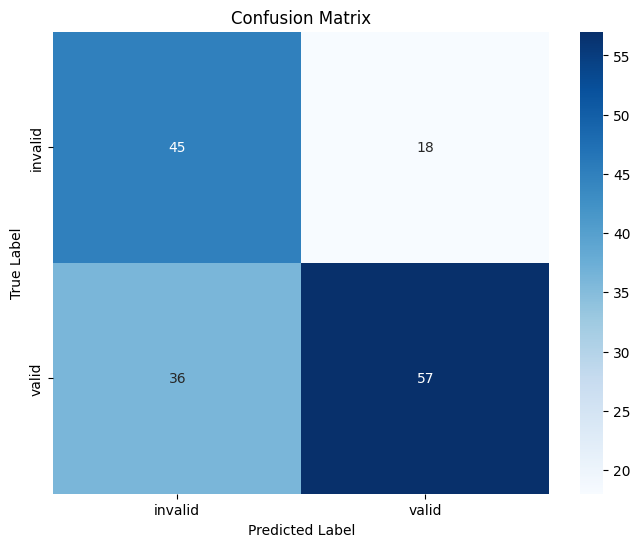

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Found 54 misclassified samples.
18 samples where invalid was classified as valid:


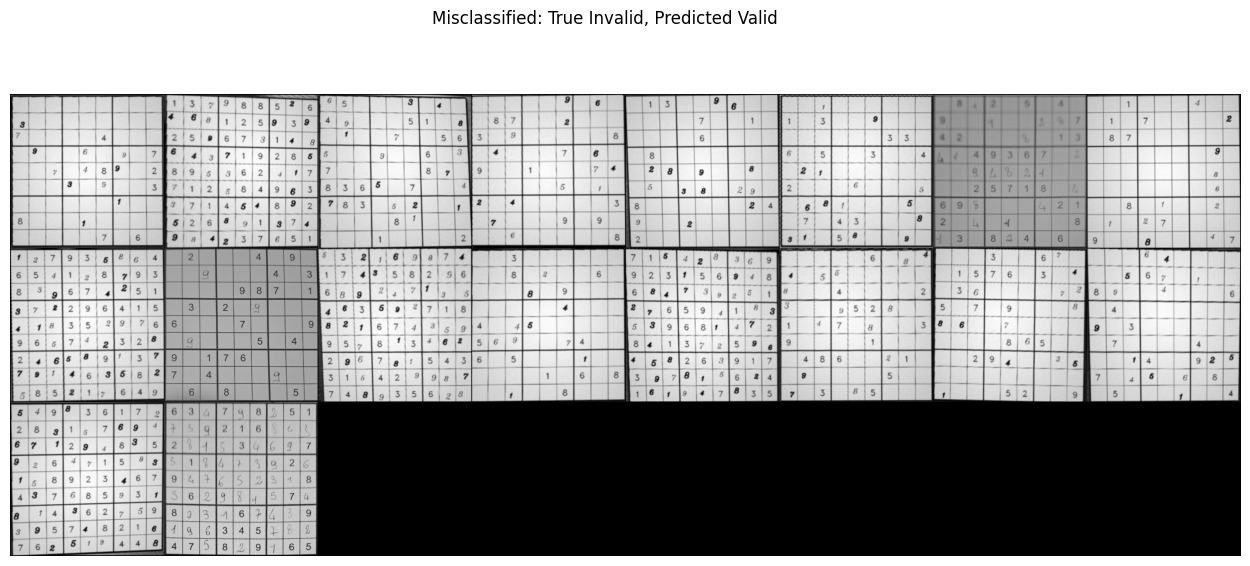

36 samples where valid was classified as invalid:


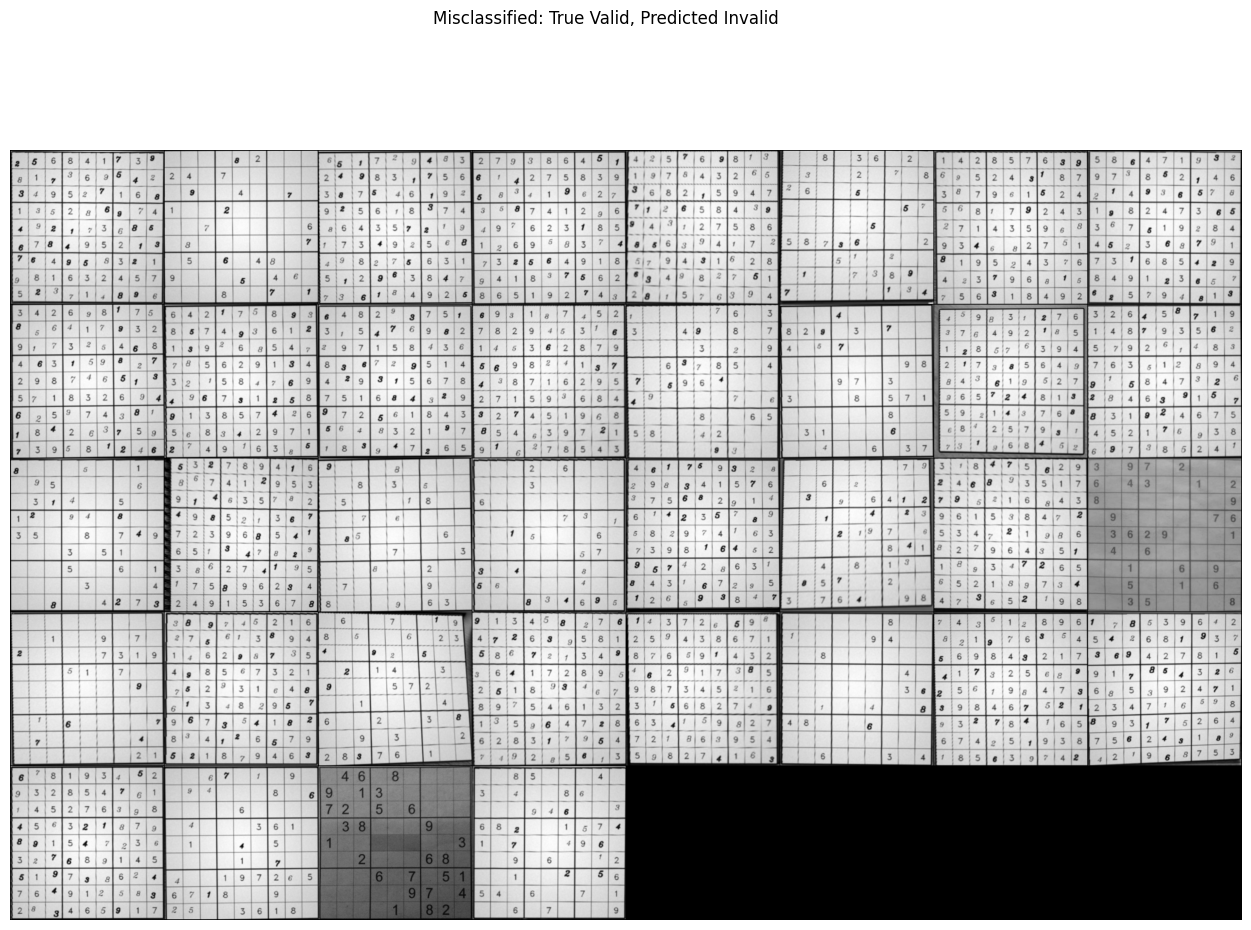

In [ ]:
print(f"Found {len(misclassified_images)} misclassified samples.")

invalid_as_valid_images = []
invalid_as_valid_labels = []
invalid_as_valid_preds = []

valid_as_invalid_images = []
valid_as_invalid_labels = []
valid_as_invalid_preds = []

for i in range(len(misclassified_images)):
    true_label = misclassified_labels[i].item()
    pred_label = misclassified_preds[i].item()

    # Case 1: True label is invalid (0) but predicted as valid (1)
    if true_label == dataset.class_to_idx['invalid'] and pred_label == dataset.class_to_idx['valid']:
        invalid_as_valid_images.append(misclassified_images[i])
        invalid_as_valid_labels.append(misclassified_labels[i])
        invalid_as_valid_preds.append(misclassified_preds[i])
    # Case 2: True label is valid (1) but predicted as invalid (0)
    elif true_label == dataset.class_to_idx['valid'] and pred_label == dataset.class_to_idx['invalid']:
        valid_as_invalid_images.append(misclassified_images[i])
        valid_as_invalid_labels.append(misclassified_labels[i])
        valid_as_invalid_preds.append(misclassified_preds[i])

## Plotting Invalid Classified as Valid
print(f"{len(invalid_as_valid_images)} samples where invalid was classified as valid:")
if len(invalid_as_valid_images) > 0:
    n_cols = min(len(invalid_as_valid_images), 8)
    n_rows = math.ceil(len(invalid_as_valid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(invalid_as_valid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Invalid, Predicted Valid", y=1.02)
    plt.show()
else:
    print("No samples where invalid was classified as valid.")

## Plotting Valid Classified as Invalid
print(f"{len(valid_as_invalid_images)} samples where valid was classified as invalid:")
if len(valid_as_invalid_images) > 0:
    n_cols = min(len(valid_as_invalid_images), 8)
    n_rows = math.ceil(len(valid_as_invalid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(valid_as_invalid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Valid, Predicted Invalid", y=1.02)
    plt.show()
else:
    print("No samples where Valid was Classified as Invalid.")